# Algoritmo de Gillespie para la expresión genética de un circuito genético retroalimentado

Considérese una célula ideal que únicamente posee dos genes interconectados entre sí en la formma que se muestra a continuación

![Circuito Oscilatorio](Inverso.PNG "Circuito")

Las ecuaciones diferenciales deterministas que describen la expresión genética del sistema, siguiendo lo postulado por el dogma central de la biología molecular, serán

\begin{equation}
\dot{r}_1 = \beta_1 \left(\frac{p_2^{n_1}}{p_2^{n_1} + k_1^{n_1}}\right) - \gamma_r r_1
\end{equation}

\begin{equation}
\dot{p}_1 = k_{p_1} r_1  - \gamma_p p_1
\end{equation}

\begin{equation}
\dot{r}_2 = \beta_2 \left(\frac{1}{1+ \left(\frac{p_1}{k_2}\right)^{n_2}}\right) - \gamma_r r_2
\end{equation}

\begin{equation}
\dot{p}_2 = k_{p_2} r_2 - \gamma_p p_2
\end{equation}

si asumimos idénticas las tasas de degradación de ambas proteínas.

Importamos los paquetes que utilizaremos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import progressbar
from tqdm import tqdm

from numba import jit,njit,float64,int32
import numba as nb

E inicializamos las constantes.

In [2]:
n1 = 3.5
n2 = 3.5
k1 = 4400 
k2 = 8080
γr1 = 1/5
γr2 = 50/251
β1 = 216/125
β2 = 216/125
kp1 = 50 
kp2 = 45
γp1 = 1/45
γp2 = 1/45

In [3]:
@njit('f8[:](f8[:],f8)')
def Gillespie(trp0,tmax):
    
    '''
    Gillespie(trp0, tmax)

    Return a ndarray from the given initial state with the last times, number of mRNA and the last number of proteins.
    
    Parameters
    ----------
    trp0 : array like
        Array like with the initial state of a every single cell. It must be in this order: initial time,
        initial number of mRNA transcribed from gene 1, initial number of mRNA transcribed from gene 2,
        initial number of proteins translated from gene 1 and initial number of mRNA transcribed from gene 2.
        
    tmax : int
        Maximum time to be run in the simulation.
    
    Returns
    -------
    out : ndarray
        Array of the last time, number of mRNAs and the last number of proteins obtained after the stochastic 
        simulation of a single system. The array is organized following the same input order.
    
    '''
    
    t,r1,r2,p1,p2 =trp0 

    while t < tmax:
        s1 = β1*((p2**n1)/(k1**n1 + p2**n1))
        s2 = γr1*r1 
        s3 = β2/(1 + (p1/k2)**n2)  
        s4 = γr2*r2  
        s5 = kp1*r1 
        s6 = γp1*p1 
        s7 = kp2*r2 
        s8 = γp2*p2
        st = s1+s2+s3+s4+s5+s6+s7+s8
        τ = (-1/st)*np.log(np.random.rand())
        x = np.random.rand()
        if(x< s1/st):
            r1+=1
        elif(x < (s1+s2)/st):
            r1-=1
        elif(x<(s1+s2+s3)/st):
            r2+=1
        elif(x<(s1+s2+s3+s4)/st):
            r2-=1
        elif(x<(s1+s2+s3+s4+s5)/st):
            p1+=1
        elif(x<(s1+s2+s3+s4+s5+s6)/st):
            p1-=1
        elif(x<(s1+s2+s3+s4+s5+s6+s7)/st):
            p2+=1
        else:
            p2-=1
        t+=τ
    return np.array([t,r1,r2,p1,p2])

In [4]:
def Estado_celula(X0,tiempos):
    
    '''
    Estado_celula(X0,tiempos)

    Returns a matrix with the evolved genetic expression of a single cell.
    
    Parameters
    ----------
    X0 :ndarray 
        Vector with the system's initial state.
        It has as many rows as elements have tiempos and as many columns as evaluated chemical species.
    tiempos : numpy linspace, ndarray, array like
        Vector containing the sampling times to evolve the system.
    
    Returns
    -------
    out : matrix, 2D ndarray
        2D ndarray with the evolved system data.
    
    Example
    --------
    >>> x0 = np.array([0.0,0.0,0.0])             #time starts in 0.0, number of mRNA starts in 0.0 
                                                 #and number of proteins starts in 0.0, respectively.
                                               
    >>> Estado_celula(x0,np.linspace(0,200,10))  #Evolves a single cell with initial conditions x0 and a
                                                 #equispaced sampling time vector with 10 elements from 
                                                 #0 to 200. We chose only 10 elements for simplicity, but
                                                 #there are 50 by default. 
                                               
    array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
    [2.22233941e+01, 6.00000000e+00, 4.58400000e+03],
    [4.44470482e+01, 3.00000000e+00, 7.73200000e+03],
    [6.66697353e+01, 5.00000000e+00, 5.90500000e+03],
    [8.88922698e+01, 4.00000000e+00, 5.80100000e+03],
    [1.11113080e+02, 6.00000000e+00, 7.65800000e+03],
    [1.33335290e+02, 7.00000000e+00, 6.79300000e+03],
    [1.55556091e+02, 7.00000000e+00, 1.00870000e+04],
    [1.77778084e+02, 2.00000000e+00, 9.95200000e+03],
    [2.00003693e+02, 3.00000000e+00, 8.36100000e+03]])
    
    Note that the first row is the initial condition vector x0.

    '''
    
    X = np.zeros((len(tiempos),len(X0)))
    X[0] = X0
    
    for i in range(1,len(tiempos)):
        X[i] = Gillespie(X[i-1],tiempos[i])
    
    return X

In [5]:
x0 = np.array([0.,0.,0.,0.,0.])

In [6]:
%%time
una_celula = Estado_celula(x0,np.arange(0,1000,0.01,dtype=float))

CPU times: user 297 ms, sys: 0 ns, total: 297 ms
Wall time: 300 ms


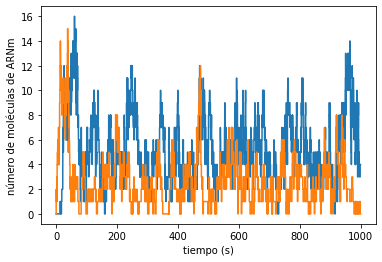

In [7]:
plt.xlabel('tiempo (s)')
plt.ylabel('número de moléculas de ARNm')
plt.step(una_celula[:,0],una_celula[:,1])
plt.step(una_celula[:,0],una_celula[:,2])

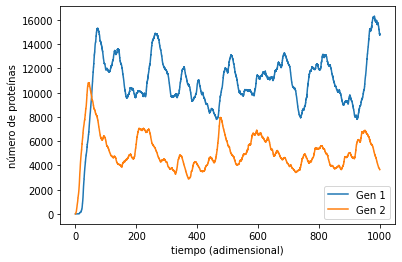

In [8]:
plt.xlabel('tiempo (adimensional)')
plt.ylabel('número de proteínas')
plt.step(una_celula[:,0],una_celula[:,3])
plt.step(una_celula[:,0],una_celula[:,4])
plt.legend(["Gen 1", "Gen 2"], loc ="lower right")

In [9]:
%%time
tiempos = np.arange(0,800.)
num_cel = 8000 #número de células 
celulas = np.array([Estado_celula(x0,tiempos) for i in range(num_cel)])
celulas.shape

CPU times: user 10min 4s, sys: 2.66 s, total: 10min 7s
Wall time: 10min 18s


(8000, 800, 5)

In [10]:
celulas_prom = np.mean(celulas,axis=0) #axis = 0 saca el promedio componente a componente de cada célula.
celulas_prom;

In [11]:
celulas.shape

(8000, 800, 5)

In [12]:
T,*sols = np.loadtxt("data3.csv",delimiter=",",unpack=True)
sols = np.array(sols)
sols[:,-1]

array([4.79490458e+00, 2.31388905e+00, 1.07868549e+04, 4.68639851e+03])

In [13]:
celulas_prom.shape

(800, 5)

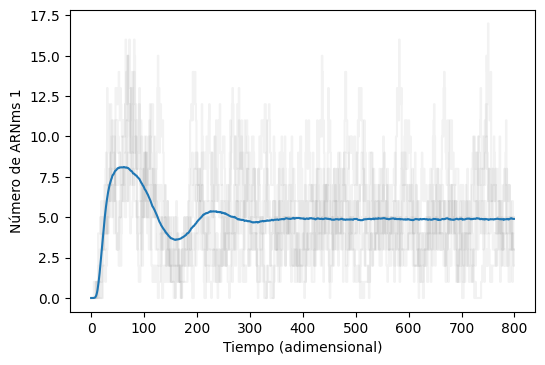

In [14]:
plt.figure(dpi=100)
plt.xlabel('Tiempo (adimensional)')
plt.ylabel('Número de ARNms 1')
plt.plot(celulas_prom[:,0],celulas_prom[:,1],zorder=100)
for i in range(5):
    plt.step(celulas[i,:,0],celulas[i,:,1],c = "gray",alpha=0.1)
#el primero es la célula, el 2do es la fila 
#y el tercero, como es 0, es el tiempo. 
#Cuando es 2 es proteína. Depende de las especies 
#químicas que use.

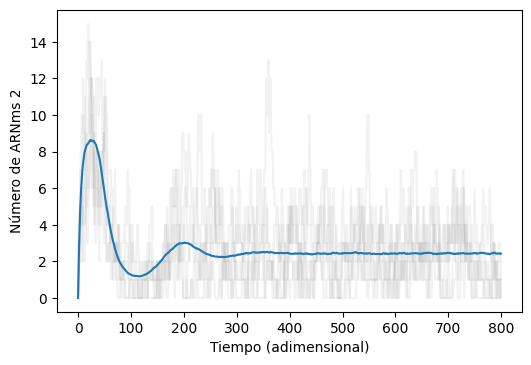

In [15]:
plt.figure(dpi=100)
plt.xlabel('Tiempo (adimensional)')
plt.ylabel('Número de ARNms 2')
plt.plot(celulas_prom[:,0],celulas_prom[:,2],zorder= 100)
for i in range(5):
    plt.plot(celulas[i,:,0],celulas[i,:,2],c = "gray",alpha=0.1)

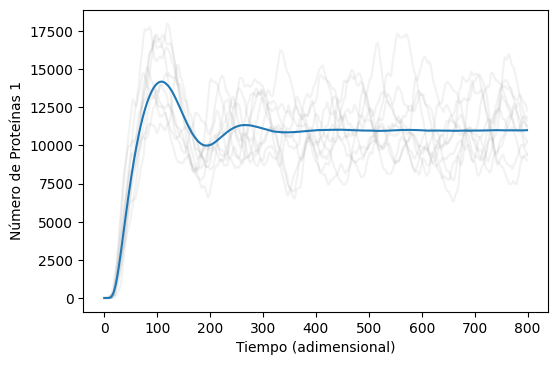

In [16]:
plt.figure(dpi=100)
plt.xlabel('Tiempo (adimensional)')
plt.ylabel('Número de Proteínas 1')
plt.plot(celulas_prom[:,0],celulas_prom[:,3],zorder= 100)
for i in range(10):
    plt.plot(celulas[i,:,0],celulas[i,:,3],c = "gray",alpha=0.1)

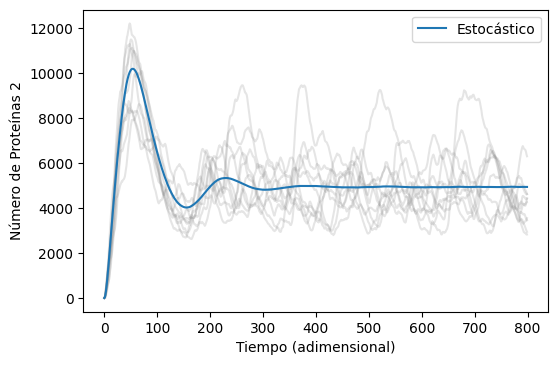

In [17]:
plt.figure(dpi=100)
plt.xlabel('Tiempo (adimensional)')
plt.ylabel('Número de Proteínas 2')
plt.plot(celulas_prom[:,0],celulas_prom[:,4],zorder= 100)
plt.legend(["Estocástico", "Determinista"])
for i in range(10):
    plt.plot(celulas[i,:,0],celulas[i,:,4],c = "gray",alpha=0.2)

In [19]:
ruido = np.std(celulas,axis=0)/celulas_prom

<ipython-input-19-ac6b00529f84>:1: RuntimeWarning: invalid value encountered in true_divide
  ruido = np.std(celulas,axis=0)/celulas_prom


In [20]:
ñ1 = np.std(celulas[:,600:800,1],axis=0).mean(axis=0)
ñ2 = np.std(celulas[:,600:800,2],axis=0).mean(axis=0)
ñ3 = np.std(celulas[:,600:800,3],axis=0).mean(axis=0)
ñ4 = np.std(celulas[:,600:800,4],axis=0).mean(axis=0)

In [21]:
mask = celulas_prom[:,0] > 600

In [32]:
print("ARNm del gen 1 promedio:", celulas_prom[mask].mean(axis=0)[1])
print("ARNm del gen 2 promedio:", celulas_prom[mask].mean(axis=0)[2])
print("Proteína del gen 1 promedio:", celulas_prom[mask].mean(axis=0)[3])
print("Proteína del gen 2 promedio:", celulas_prom[mask].mean(axis=0)[4])

ARNm del gen 1 promedio: 4.880736874999999
ARNm del gen 2 promedio: 2.4362412499999997
Proteína del gen 1 promedio: 10982.148084374996
Proteína del gen 2 promedio: 4928.565570625002


In [33]:
print("Ruido cuadrado en el ARNm del gen 1:",(np.mean(ruido[mask],axis=0)**2)[1])
print("Ruido cuadrado en el ARNm del gen 2:",(np.mean(ruido[mask],axis=0)**2)[2])
print("Ruido cuadrado en las proteínas del gen 1:",(np.mean(ruido[mask],axis=0)**2)[3])
print("Ruido cuadrado en las proteínas del gen 2:",(np.mean(ruido[mask],axis=0)**2)[4])

Ruido cuadrado en el ARNm del gen 1: 0.2959679961245225
Ruido cuadrado en el ARNm del gen 2: 0.5728860806780876
Ruido cuadrado en las proteínas del gen 1: 0.03100253052993909
Ruido cuadrado en las proteínas del gen 2: 0.056570727702649926
